**Восстановление смеси плотностей распределений.**

алгоритм EM (базовый) с фиксированным количеством компонент смеси

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
import numpy as np
from numpy import random as rng
# np.set_printoptions(precision=2)
import matplotlib.pyplot as plt

##  загружаем данные 

(512, 2)

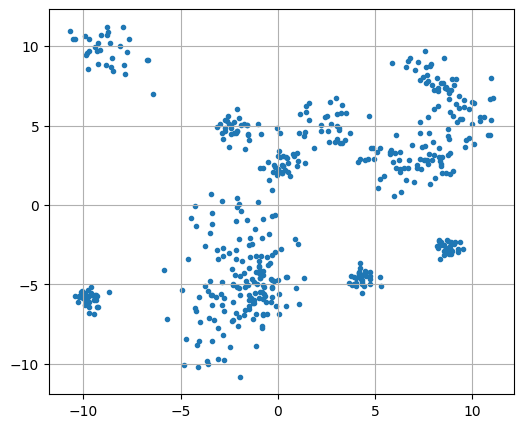

In [25]:
from sklearn.datasets import make_blobs

n_components = 16 # количество компонент

X,_ = make_blobs( 
    n_samples=512, 
    centers=n_components, 
    cluster_std=np.abs(rng.normal(loc=1.,scale=.3,size=n_components))
)
display( X.shape )

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter( x=X[:,0], y=X[:,1], marker='.' )
ax.grid()

In [26]:
# from sklearn.preprocessing import StandardScaler
# X = StandardScaler().fit_transform(X)

## инициализация параметров

-----

фунция n-мерной нормальной плотности распределения
$$
\varphi(x;\theta)
=\mathcal{N}(x;\Sigma,\mu)
=\frac{ \exp\left( -\frac{1}{2}(x-\mu)^T \cdot \Sigma^{-1} \cdot (x-\mu) \right)  }
      { \sqrt{ (2\pi)^n \det \Sigma } }
$$

In [27]:
# фунция n-мерной нормальной плотности распределения
class GaussDensity:
    
    def __init__(self,mu=np.array([]),sigma=np.array([])):
        self._mu = mu
        self._isigma = np.array([])
        self._d = 1.
        self._sigma = sigma
        if len(sigma)>0:
            self._init_param()
            
    def _init_param(self):
        assert len(self._sigma)>0
        assert len(self._sigma.shape)==2
        assert self._sigma.shape[0]==self._sigma.shape[1]
        n = self._sigma.shape[0] # размерность пространства
        self._isigma = np.linalg.inv(self._sigma)
        self._d = np.sqrt( (2.*np.pi)**n * np.linalg.det(self._sigma)  )
        return self
            
    def score(self,x):
        assert len(x)>0
        assert len(x.shape)==2
        assert self._mu.shape[1]==x.shape[1]
        d = x - self._mu
        return np.exp(-.5 * np.diag( d.dot(self._isigma).dot(d.T) ) ) / self._d
    
    
    def fit(self,x):
        n = x.shape[1] # размерность пространства
        self._mu = x.mean(axis=0,keepdims=True)
        self._sigma = np.cov(x.T)
        assert self._sigma.shape[1]==self._mu.shape[1]
        self._init_param()
        return self
    
    @property
    def mu(self): return self._mu
    
    @property
    def sigma(self): return self._sigma

модель смесь плотностей распределения

$$
\sum\limits_i w_i \cdot \varphi(x;\theta_i)
$$

__EM:__



оценка параметров

$$
g_{ij} = \frac{ w_j \cdot \mathcal{N}(x_i;\Sigma_j,\mu_j) }
              { \sum\limits_k w_k \cdot \mathcal{N}(x_i;\Sigma_k,\mu_k) }
$$



изменение параметров

$$
w_j = \frac{1}{m}\sum\limits_{i=1}^{m} g_{ij}
$$

$$\cdots$$

In [28]:
from tqdm.auto import tqdm

In [53]:
class DensityMix:
    
    def __init__(self,weight=[],components=[]):
        assert len(weight)==len(components)
        self._weight = weight
        self._components = components

    def score(self,x):
        assert len(x)>0
        assert len(x.shape)==2
        assert len(self._weight)>0
        # assert sum(self._weight)==1., self._weight
        assert len(self._components)==len(self._weight)
        return np.vstack([ w*g.score(x) for w,g in zip(self._weight,self._components) ]).T
    
    def predict(self,x): 
        return self.score(x).sum(axis=1)
               
    def fit(self,x,n_components,delta=1e-5,max_iter=1024): 
        self._init_params(x,n_components)
        g_ = np.zeros([x.shape[0],n_components]) 
        for i in tqdm(range(max_iter)):
            g = self._e_step(x) # оценка параметров
            assert not np.isnan(g).any(), g # 'ошибка вычислений, неудачные начальные параметры'
            dg = np.abs(g-g_).max() # считаем изменение оценки
            #  проверяем условия завершения работы
            if(dg<delta): break # изменение оценки ниже порога, конец работы
            self._m_step(x,g) # оптимизация параметров
            g_ = g # сохраняем старую оценку параметров
        return self
                
    def _init_params(self,x,n_components): 
        pass
    
    def _e_step(self,x): 
        s = self.score(x)
        assert (s.sum(axis=1)!=0.).all(), s
        return s/s.sum(axis=1,keepdims=True)
             
    def _m_step(self,x,g): 
        self._weight = g.sum(axis=0)/g.shape[0] # g.sum()
        self._m_step_components(x,g)
        return self
        
    def _m_step_components(self,x,g): pass

    @property
    def weight(self): return self._weight
    
    @property
    def components(self): return self._components

In [54]:
from sklearn.metrics.pairwise import euclidean_distances as metric

__EM:__

изменение параметров для GaussMix

$$\cdots$$

$$
N_j = \sum\limits_{i=1}^{m} g_{ij}\ \ ;\ \ \
\mu_j = \frac{1}{ N_j } \sum\limits_{i=1}^{m} g_{ij} \cdot x_i
$$

$$
\Sigma_j = \frac{1}{ c\cdot N_j} 
                \cdot \sum\limits_i g_{ij}(x_i-\mu_j)^T(x_i-\mu_j)\ \ \ ; \ \ 
0 < c \leq 1
$$


In [55]:
from sklearn.cluster import KMeans

In [56]:
class GaussMix(DensityMix):
    
    def __init__(self,weight=[],components=[],):
        if len(weight)>0:
            assert len(weight)==len(components)
            assert all([ w>0. for w in weight ])
            assert sum(weight)==1.
            assert all([ c.__class__.__name__ == 'GaussDensity' for c in components ])
        super().__init__(weight,components)

    def _init_params(self,x,n_components):
        # labels = self._split_dataset(x,n_components) # размечаем датасет по ближайшим mu
        model = KMeans(n_clusters=n_components, max_iter=9).fit(x)
        mu, sigma = model.cluster_centers_, np.cov(x.T)
        self._components = [ GaussDensity(mu=mu[[n],:],sigma=sigma) for n in range(n_components) ]
        # self._components = [ GaussDensity().fit(x[labels==n,:])  for n in range(n_components) ]
        # начальные веса компонент (априорная вероятность)
        self._weight = np.ones(n_components)/n_components 
        return model.labels_
    
    @staticmethod
    def _split_dataset(x,n_components):
        sc = (np.abs(x).max(axis=0)-np.abs(x).min(axis=0))/2.
        mu = ( # выбираем случайные мат.ожидания 
            x.mean(axis=0,keepdims=True)
            +rng.normal(size=(n_components,x.shape[1]),scale=sc )
        )
        return np.argmin(metric(x,mu),axis=1) # размечаем датасет по ближайшим mu    
    
    def _m_step_components(self,x,g,g_factor=0.99):
        gs = g.sum(axis=0)
        n_components = len(gs) # количество компонент смеси
        
        mu = [ (x*g[:,[n]]).sum(axis=0,keepdims=True)/gs[n] for n in range(n_components) ]
        dx = [ (x-mu[n])*g[:,[n]] for n in range(n_components) ]
        sigma = [ dx[n].T.dot(dx[n])/(gs[n]*g_factor) for n in range(n_components) ]
        
        self._components = [ GaussDensity(mu=mu[n],sigma=sigma[n]) for n in range(n_components) ]
        return self    
    
    @property
    def mu(self): return [ c.mu for c in self._components  ]
    
    @property
    def sigma(self): return [ c.sigma for c in self._components  ]


In [129]:
model = GaussMix().fit(X,n_components=17)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [130]:
# model.weight, sum(model.weight), model.mu,  model.sigma

0.024164758515062085

(9.312949092622726e-05, 1.4109065808975505, 0.09196901121075009)

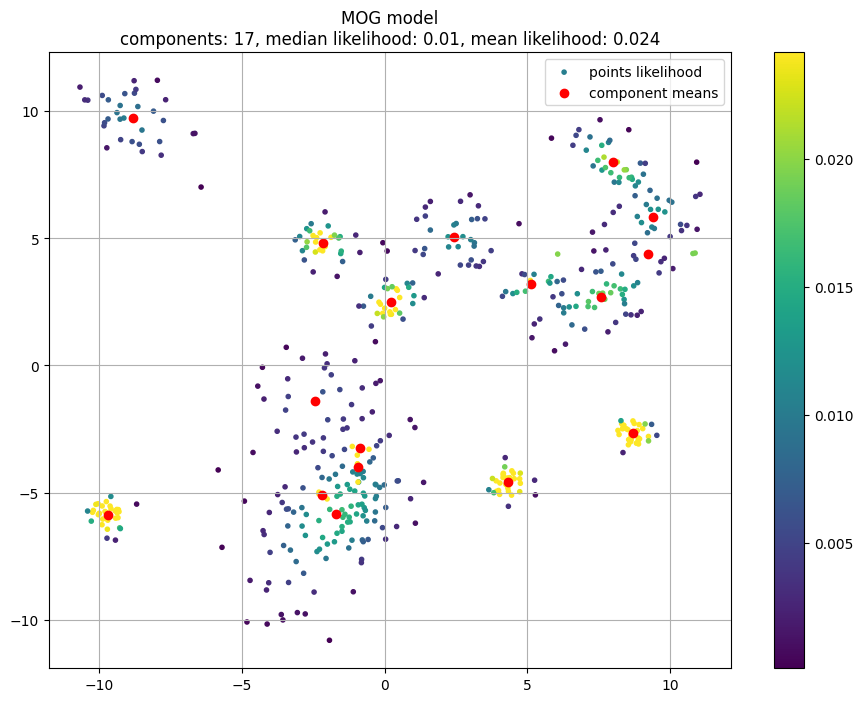

In [131]:
from sklearn.preprocessing import MinMaxScaler

mu = np.vstack(model.mu)
p = model.predict(X)
display( p.mean() ) # среднее правдоподобие
display( ( p.min(),p.max(),p.std()) )

#p = MinMaxScaler(feature_range=(0,1),).fit_transform(p.reshape(-1,1))

p_norm = p.copy()
p_norm_mean = p_norm.mean()
p_norm[p_norm>p_norm_mean] = p_norm_mean

fig, ax = plt.subplots(figsize=(11,8))
pp = ax.scatter( x=X[:,0], y=X[:,1], marker='.', c=p_norm, label='points likelihood' )
ax.scatter( x=mu[:,0], y=mu[:,1], marker='o', c='r',label='component means' )
ax.set_title(f'MOG model\ncomponents: {len(mu)}, median likelihood: {np.median(p):.2}, mean likelihood: {p.mean():.2}')
ax.grid()
ax.legend()
fig.colorbar(pp,ax=ax)
